## Configuration

In [1]:
import tapered_pareto as tp
import numpy as np
import matplotlib.pyplot as plt
import dask.array as da

In [2]:
from dask.distributed import Client, LocalCluster

cluster = LocalCluster()
client = Client(cluster)

In [10]:
plt.rcParams["figure.dpi"] = 300
plt.rcParams["savefig.dpi"] = 300

## Cumulative sums - Figures A1-A3

### Settings

In [3]:
M_T = 2.0e17
M_C = 2.0e23
beta = 2.0 / 3.0
percentiles = np.array([2, 50, 98])
quantiles = np.array(percentiles) / 100.0
n_chain = 10_000  # from which the percentiles are calculated
n_draw = 1_000_000  # number of events in hypothetical catalog
RANDOM_SEED = 42
tp_fig = tp.tapered_pareto(beta, M_T, M_C)
expectation_value = tp_fig.moment(1)
count = np.arange(1, n_draw + 1)
ref = count[:, None] * expectation_value

In [4]:
rng = da.random.default_rng(RANDOM_SEED)
moment_samples = tp.sample_tapered_pareto(
    beta, M_T, M_C, rng=rng, size=(n_chain, n_draw), chunks=(-1, "auto")
)
moment_cumsum = moment_samples.cumsum(axis=1)

In [5]:
moment_cumsum_percentiles = (
    moment_cumsum.map_blocks(np.percentile, q=percentiles, axis=0).compute().T
)

In [6]:
qnormal = tp.normal_quantile(quantiles[:, None], count, beta, M_T, M_C).T
qstable = tp.stable_quantile(quantiles[:, None], count, beta, M_T).T
approx = tp.quantile_approximator(quantiles[:, None], count, beta, M_T, M_C).T

In [7]:
RANDOM_SEED = 3
M_C_blue = M_C
M_C_red = 3.5e19
n_chain = 11
tp_blue = tp.tapered_pareto(beta, M_T, M_C_blue)
tp_red = tp.tapered_pareto(beta, M_T, M_C_red)

In [8]:
rng = da.random.default_rng(RANDOM_SEED)
moment_samples_red = (
    tp.sample_tapered_pareto(beta, M_T, M_C_red, rng=rng, size=n_draw)
    .cumsum(axis=0)
    .compute()
)
rng = da.random.default_rng(RANDOM_SEED)
moment_samples_blue_all = (
    tp.sample_tapered_pareto(beta, M_T, M_C_blue, rng=rng, size=(n_chain, n_draw))
    .cumsum(axis=1)
    .compute()
)
moment_samples_blue = moment_samples_blue_all[0]
moment_samples_blue_extra = moment_samples_blue_all[1:]

In [9]:
count = np.arange(1, n_draw + 1)

expectation_value_blue = tp_blue.mean()
ref_blue = count * expectation_value

expectation_value_red = tp_red.mean()
ref_red = count * expectation_value_red

### Figure A1

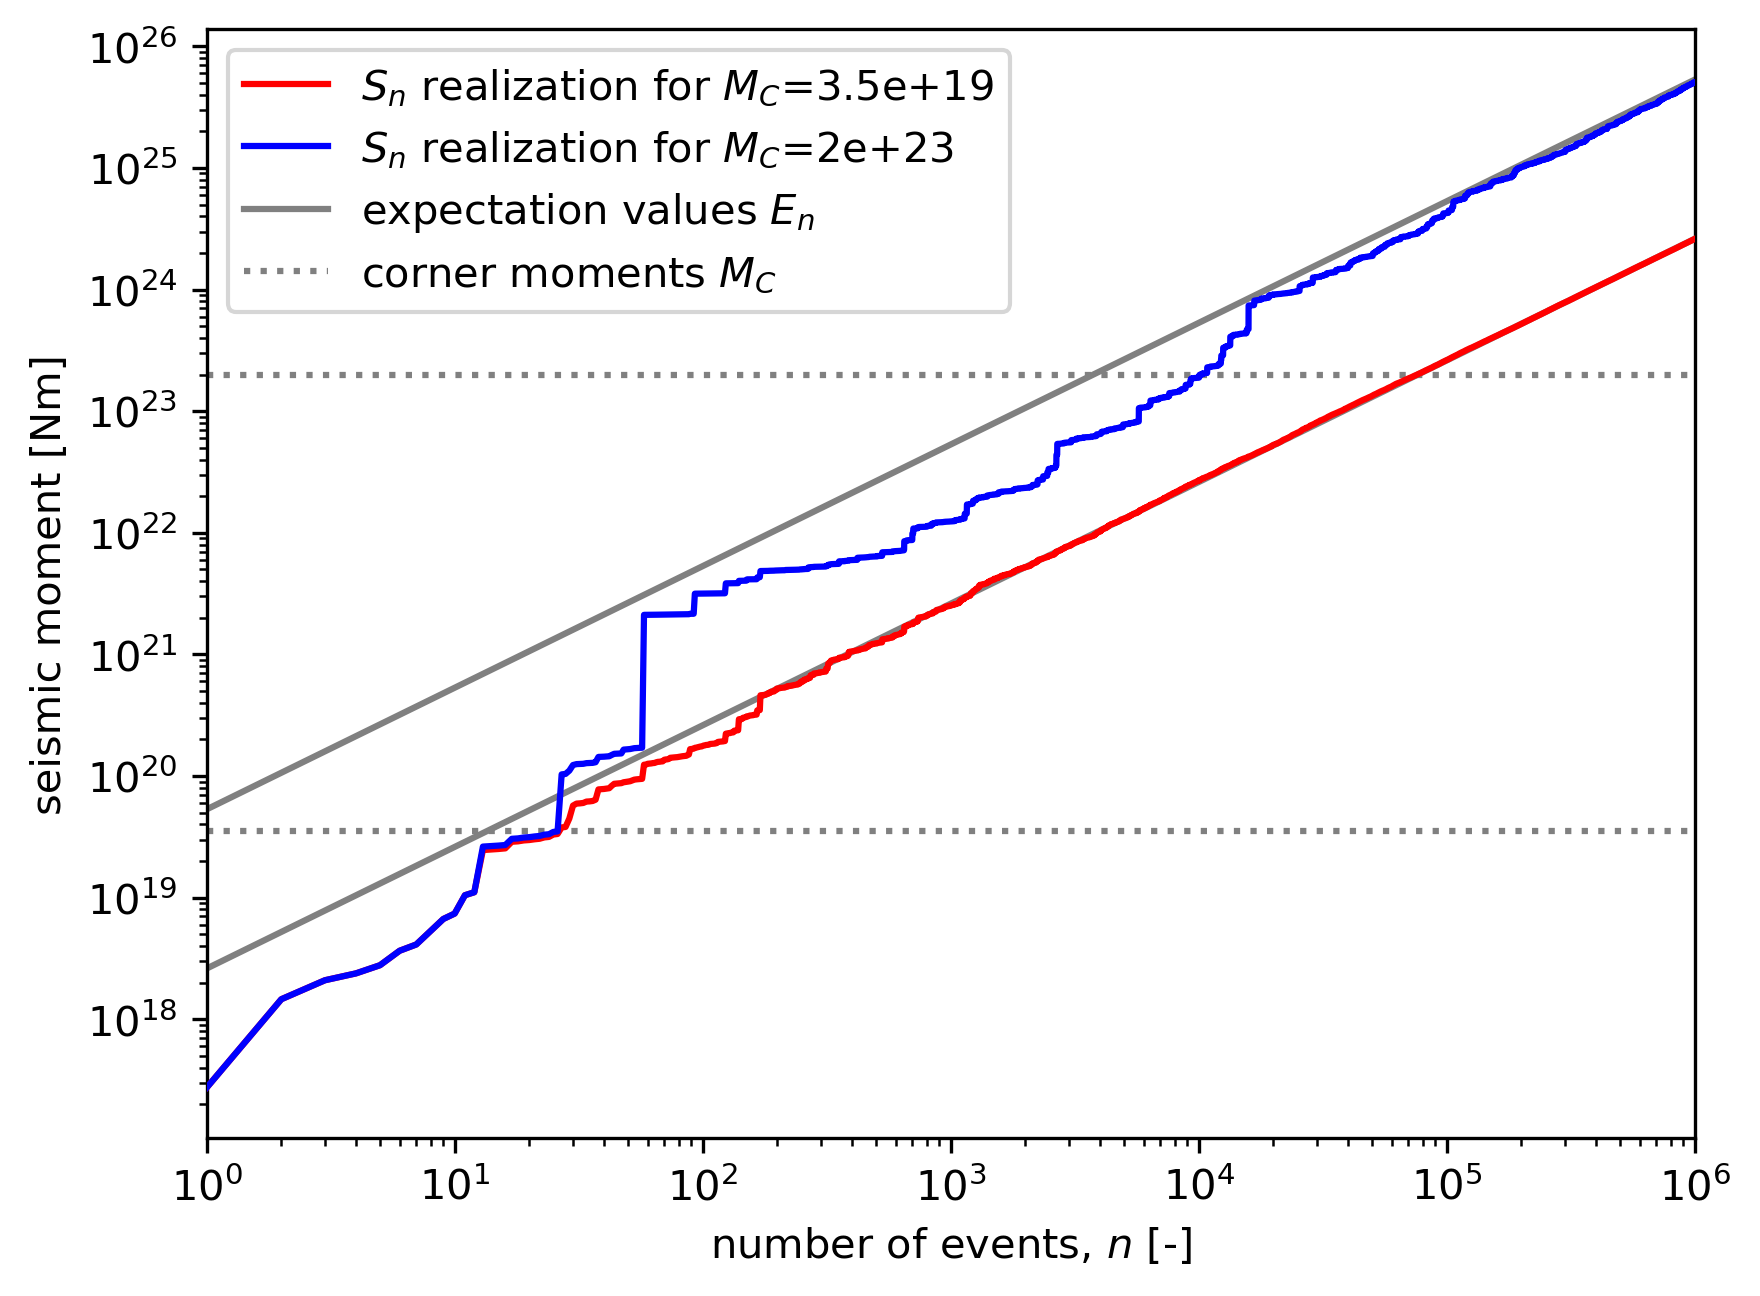

In [11]:
fig, ax = plt.subplots()
ax.set_xlim(count[0], count[-1])
ax.set_ylabel("seismic moment [Nm]")
ax.set_xlabel("number of events, $n$ [-]")
plt.loglog(
    count,
    moment_samples_red,
    color="red",
    label=f"$S_n$ realization for $M_C$={M_C_red}",
    zorder=10,
)
plt.loglog(
    count,
    moment_samples_blue,
    color="blue",
    label=f"$S_n$ realization for $M_C$={M_C_blue}",
    zorder=10,
)
plt.loglog(count, ref_blue, color="grey", zorder=0)
plt.loglog(
    count,
    ref_red,
    color="grey",
    label="expectation values $E_n$",
    zorder=0,
)
plt.axhline(
    M_C_blue,
    color="grey",
    linestyle=":",
    zorder=0,
)
plt.axhline(
    M_C_red,
    color="grey",
    linestyle=":",
    label="corner moments $M_C$",
    zorder=0,
)
_ = plt.legend(loc="best")

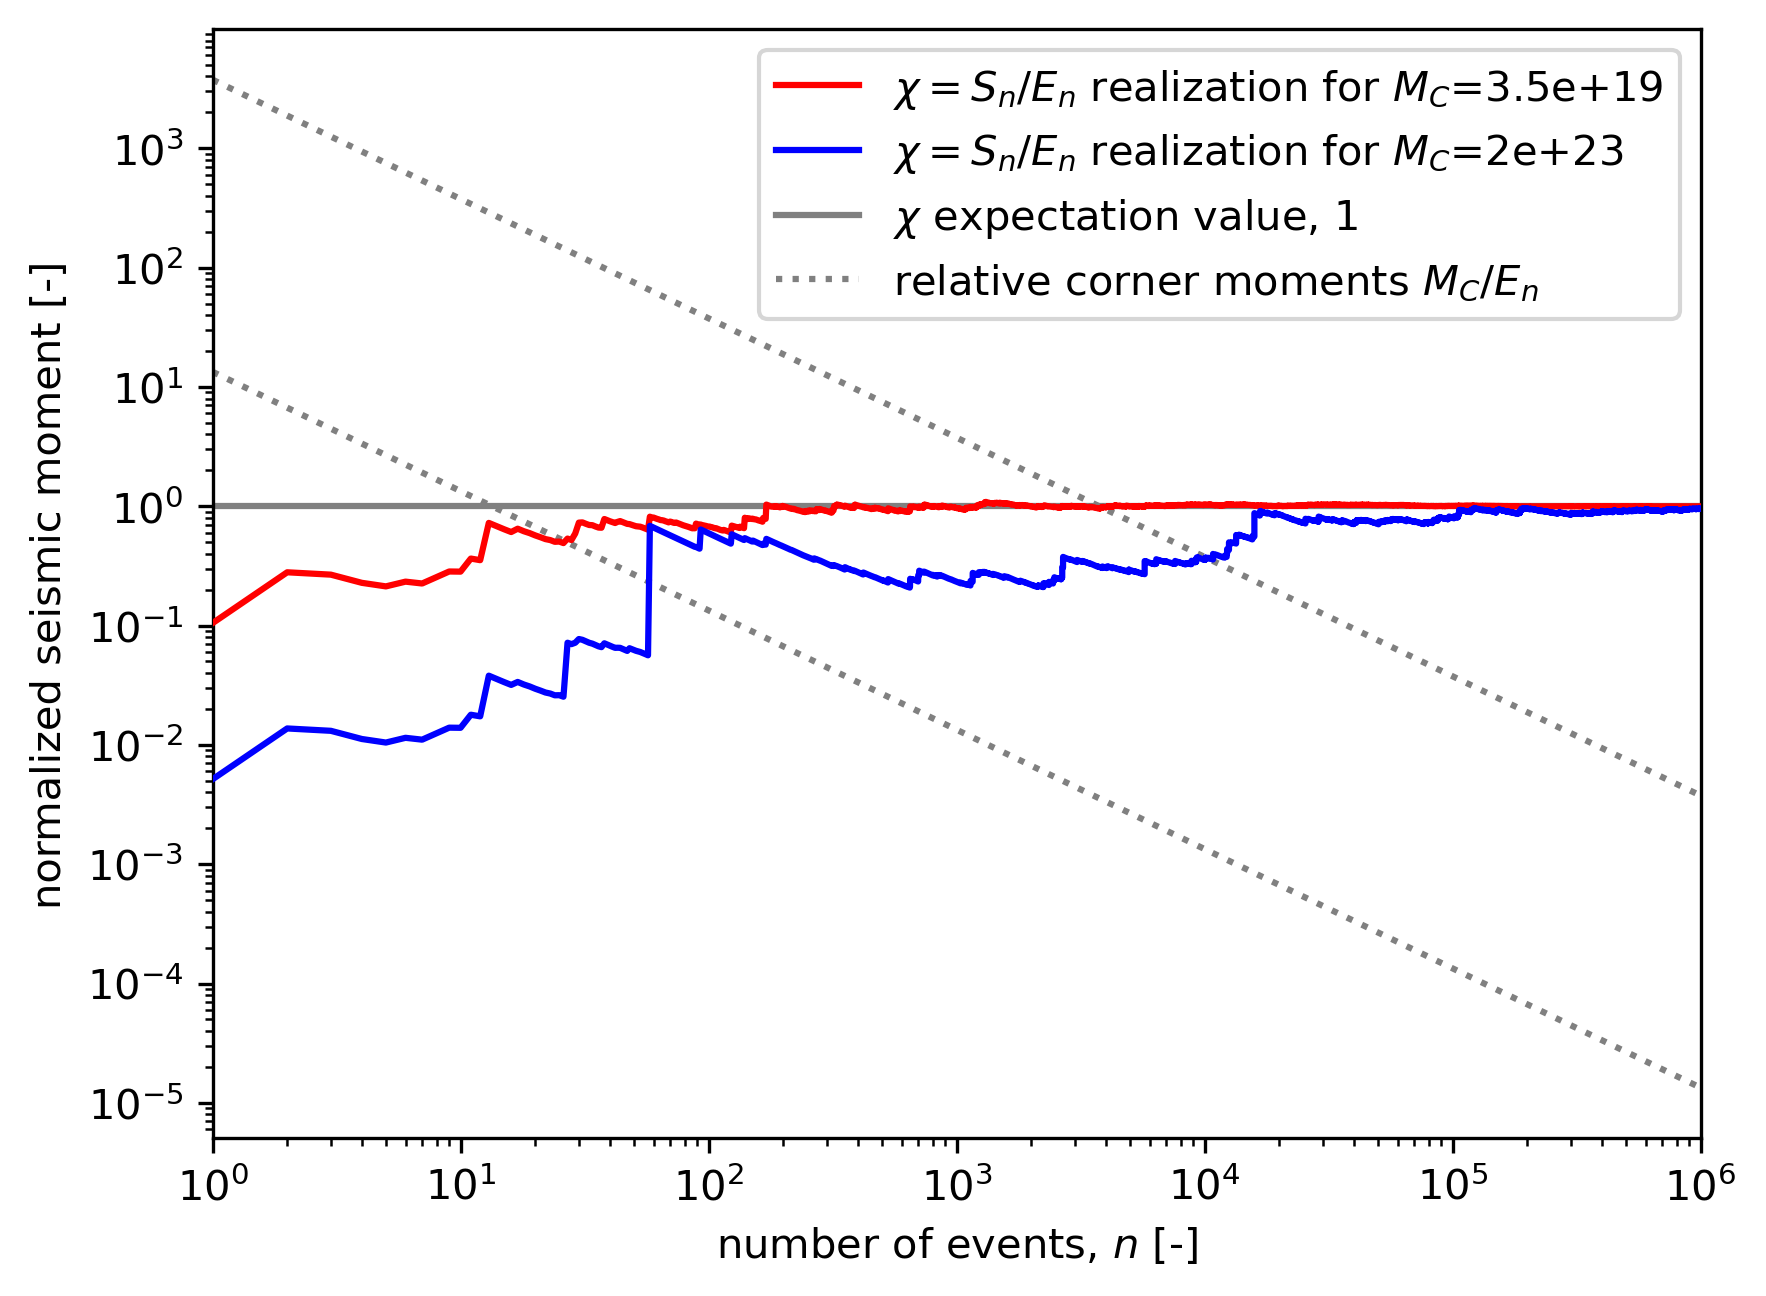

In [12]:
fig, ax = plt.subplots()
ax.set_xlim(count[0], count[-1])
ax.set_ylabel("normalized seismic moment [-]")
ax.set_xlabel("number of events, $n$ [-]")
plt.loglog(
    count,
    moment_samples_red / ref_red,
    color="red",
    label=f"$\chi=S_n/E_n$ realization for $M_C$={M_C_red}",
    zorder=10,
)
plt.loglog(
    count,
    moment_samples_blue / ref_blue,
    color="blue",
    label=f"$\chi=S_n/E_n$ realization for $M_C$={M_C_blue}",
    zorder=10,
)
plt.axhline(1, color="grey", label="$\chi$ expectation value, 1", zorder=0)
plt.loglog(count, M_C_blue / ref_blue, color="grey", linestyle=":", zorder=0)
plt.loglog(
    count,
    M_C_red / ref_red,
    color="grey",
    linestyle=":",
    label="relative corner moments $M_C/E_n$",
    zorder=0,
)
_ = plt.legend(loc="best")

### Figure A2

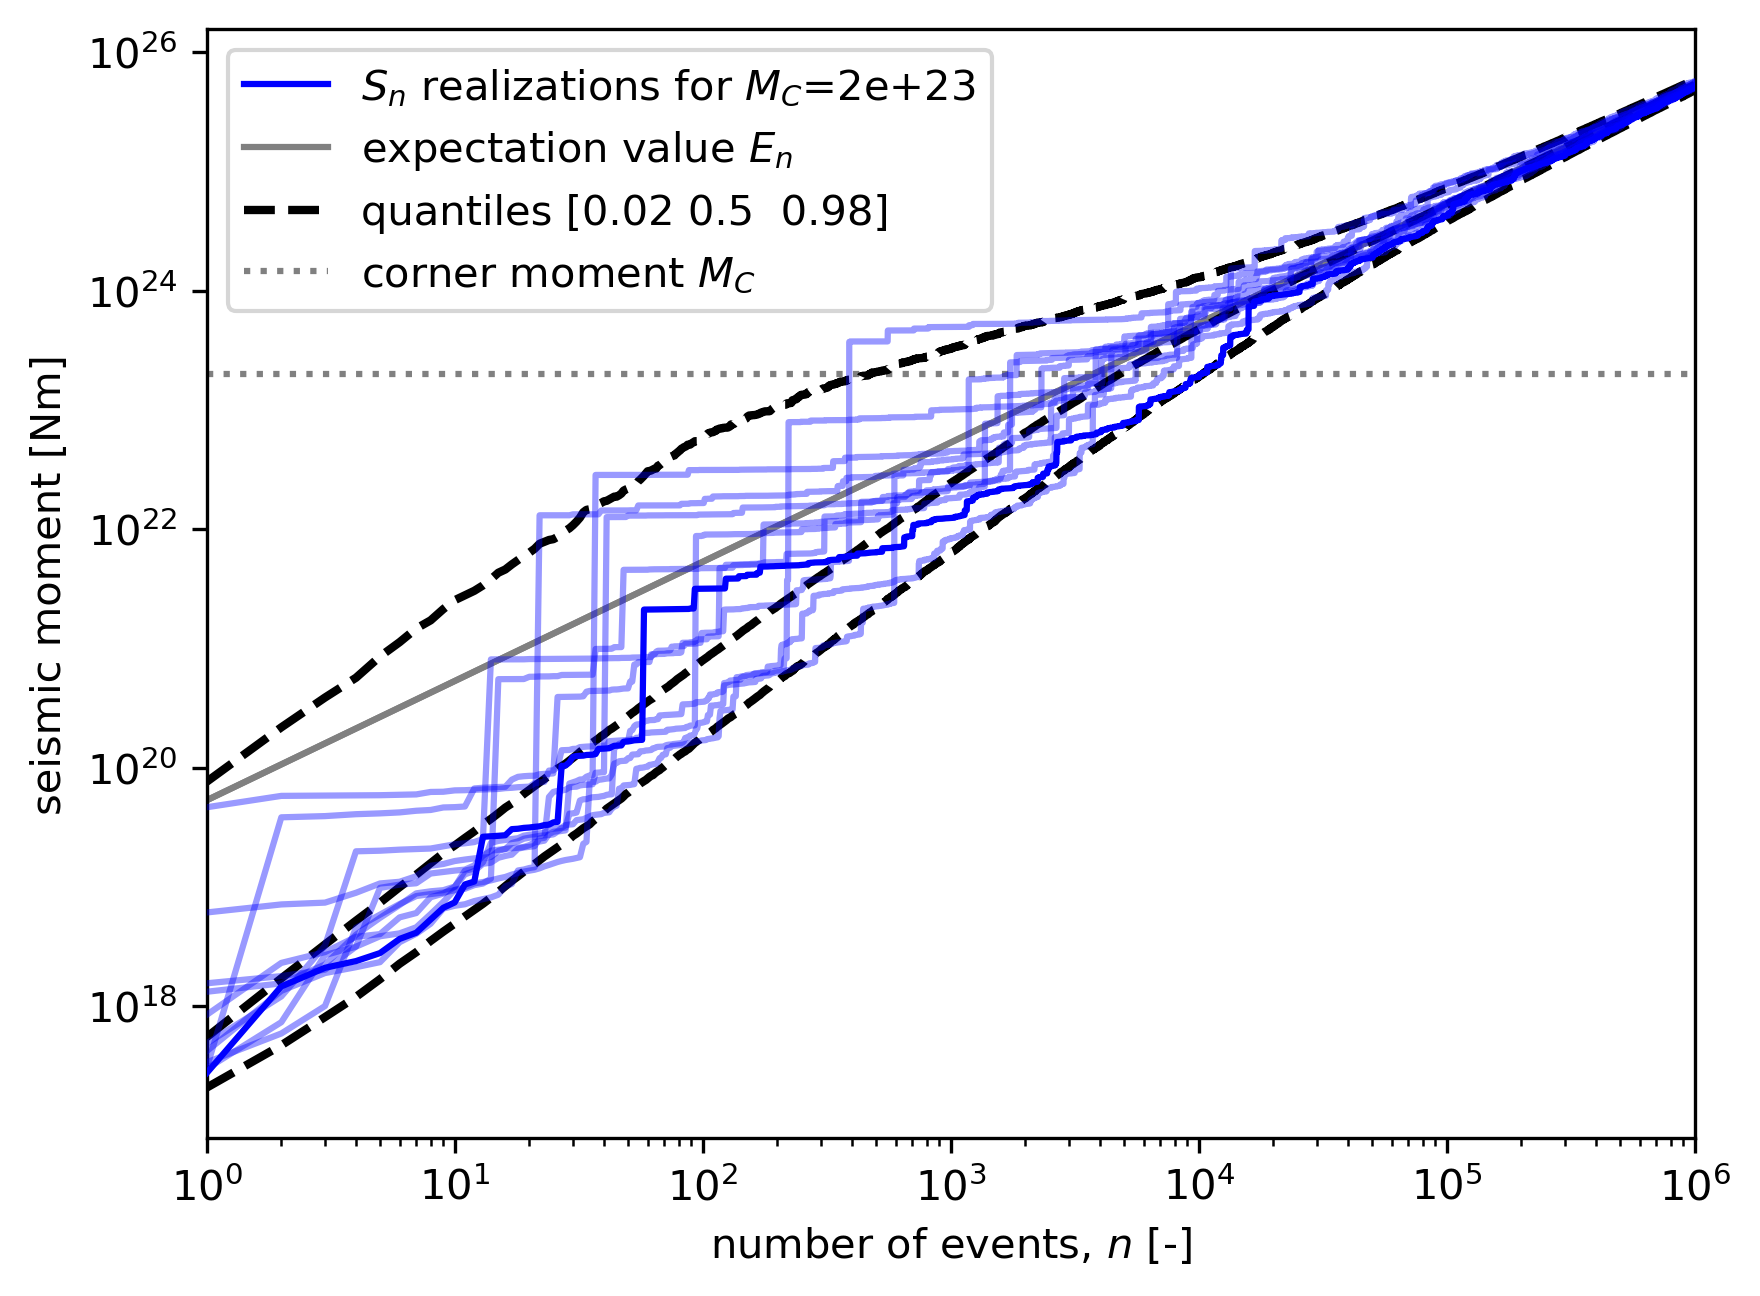

In [13]:
fig, ax = plt.subplots()
ax.set_xlim(count[0], count[-1])
ax.set_ylabel("seismic moment [Nm]")
ax.set_xlabel("number of events, $n$ [-]")
plt.loglog(
    count,
    moment_samples_blue.T,
    label=f"$S_n$ realizations for $M_C$={M_C_blue}",
    zorder=10,
    c="b",
)
plt.loglog(
    count,
    moment_samples_blue_extra.T,
    zorder=10,
    c="b",
    alpha=0.4,
)
plt.loglog(count, ref_blue, color="grey", zorder=0)
plt.loglog(
    count,
    ref_blue,
    color="grey",
    label="expectation value $E_n$",
    zorder=0,
)
plt.loglog(
    count,
    moment_cumsum_percentiles,
    linestyle="--",
    label=[f"quantiles {quantiles}", None, None],
    color="black",
    linewidth=2,
)

plt.axhline(
    M_C_blue,
    color="grey",
    linestyle=":",
    label="corner moment $M_C$",
    zorder=0,
)
_ = plt.legend(loc="best")

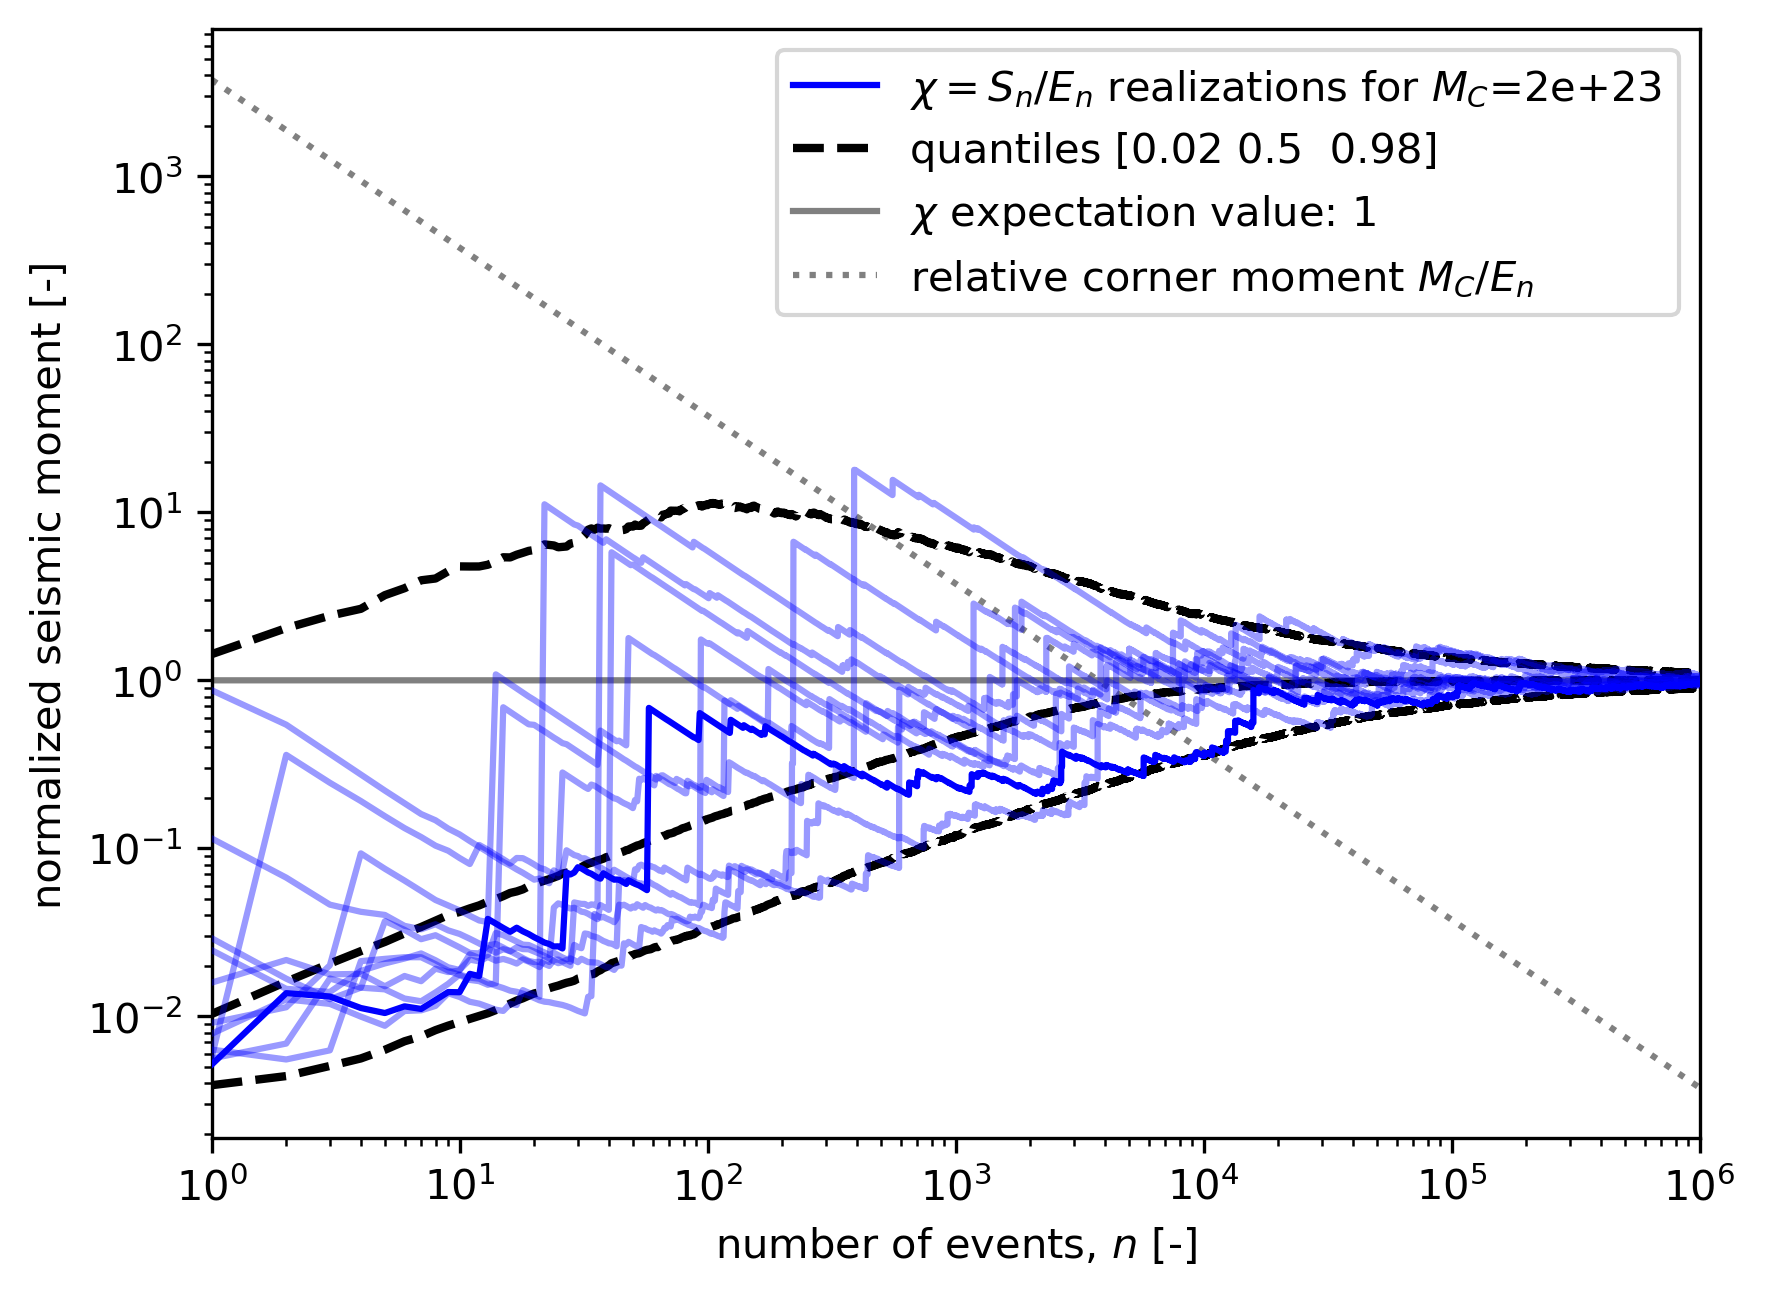

In [14]:
fig, ax = plt.subplots()
ax.set_xlim(count[0], count[-1])
ax.set_ylabel("normalized seismic moment [-]")
ax.set_xlabel("number of events, $n$ [-]")
plt.loglog(
    count,
    moment_samples_blue.T / ref_blue,
    label=f"$\chi=S_n/E_n$ realizations for $M_C$={M_C_blue}",
    zorder=10,
    c="b",
)
plt.loglog(
    count,
    moment_samples_blue_extra.T / ref_blue[:, None],
    zorder=10,
    c="b",
    alpha=0.4,
)
plt.loglog(
    count,
    moment_cumsum_percentiles / ref_blue[:, None],
    linestyle="--",
    label=[f"quantiles {quantiles}", None, None],
    color="black",
    linewidth=2,
)
plt.loglog(
    count,
    ref_blue / ref_blue,
    color="grey",
    label="$\chi$ expectation value: 1",
    zorder=0,
)
plt.loglog(
    count,
    M_C_blue / ref_blue,
    color="grey",
    linestyle=":",
    label="relative corner moment $M_C/E_n$",
    zorder=0,
)
_ = plt.legend(loc="best")

### Figure A3

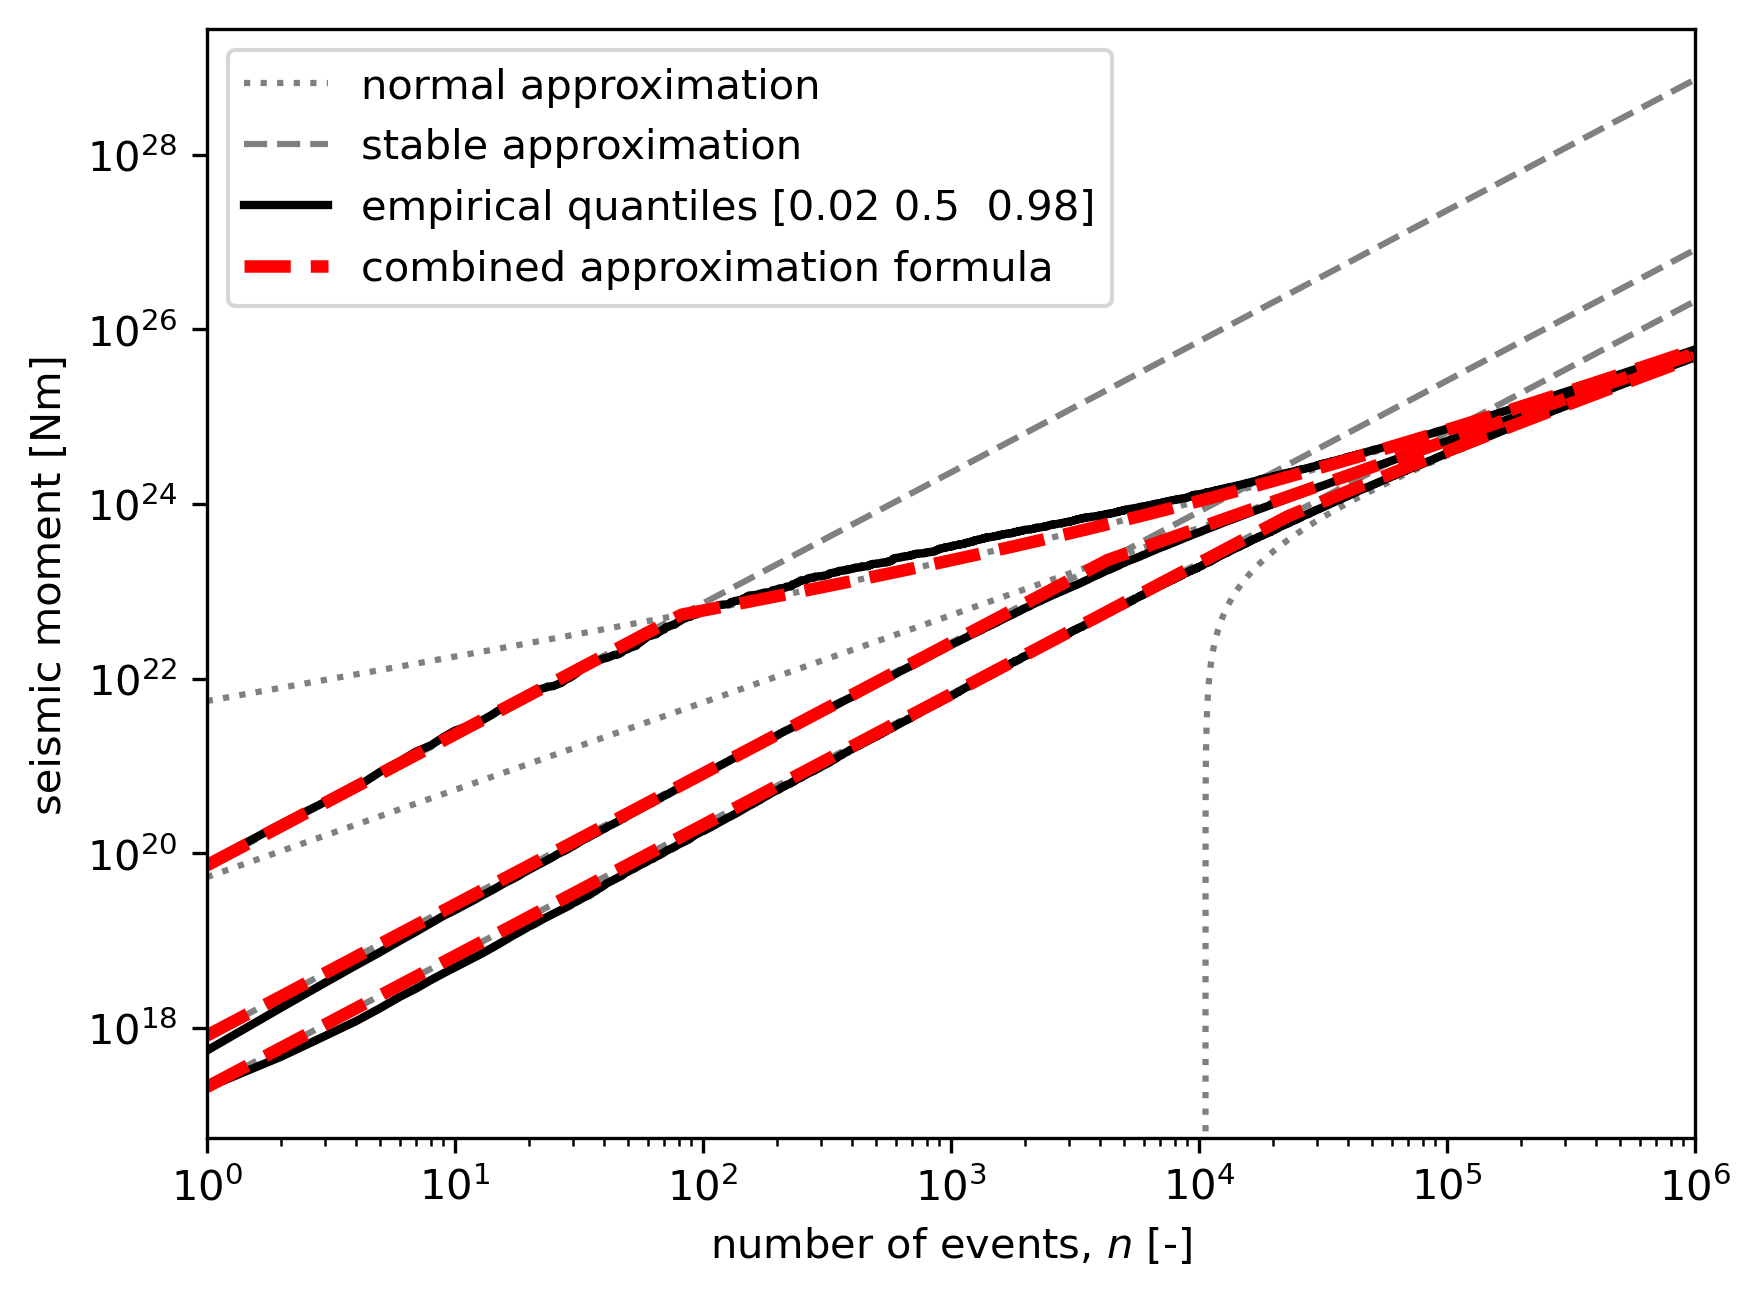

In [15]:
fig, ax = plt.subplots()
ax.set_xlim(count[0], count[-1])
ax.set_ylabel("seismic moment [Nm]")
ax.set_xlabel("number of events, $n$ [-]")
plt.loglog(
    count,
    qnormal,
    linestyle=":",
    label=[f"normal approximation", None, None],
    color="grey",
)
plt.loglog(
    count,
    qstable,
    linestyle="--",
    label=[f"stable approximation", None, None],
    color="grey",
)
plt.loglog(
    count,
    moment_cumsum_percentiles,
    linestyle="-",
    label=[f"empirical quantiles {quantiles}", None, None],
    color="black",
    linewidth=2,
)
plt.loglog(
    count,
    approx,
    linestyle="--",
    color="red",
    label=[f"combined approximation formula", None, None],
    linewidth=3,
)
_ = plt.legend(loc="best")

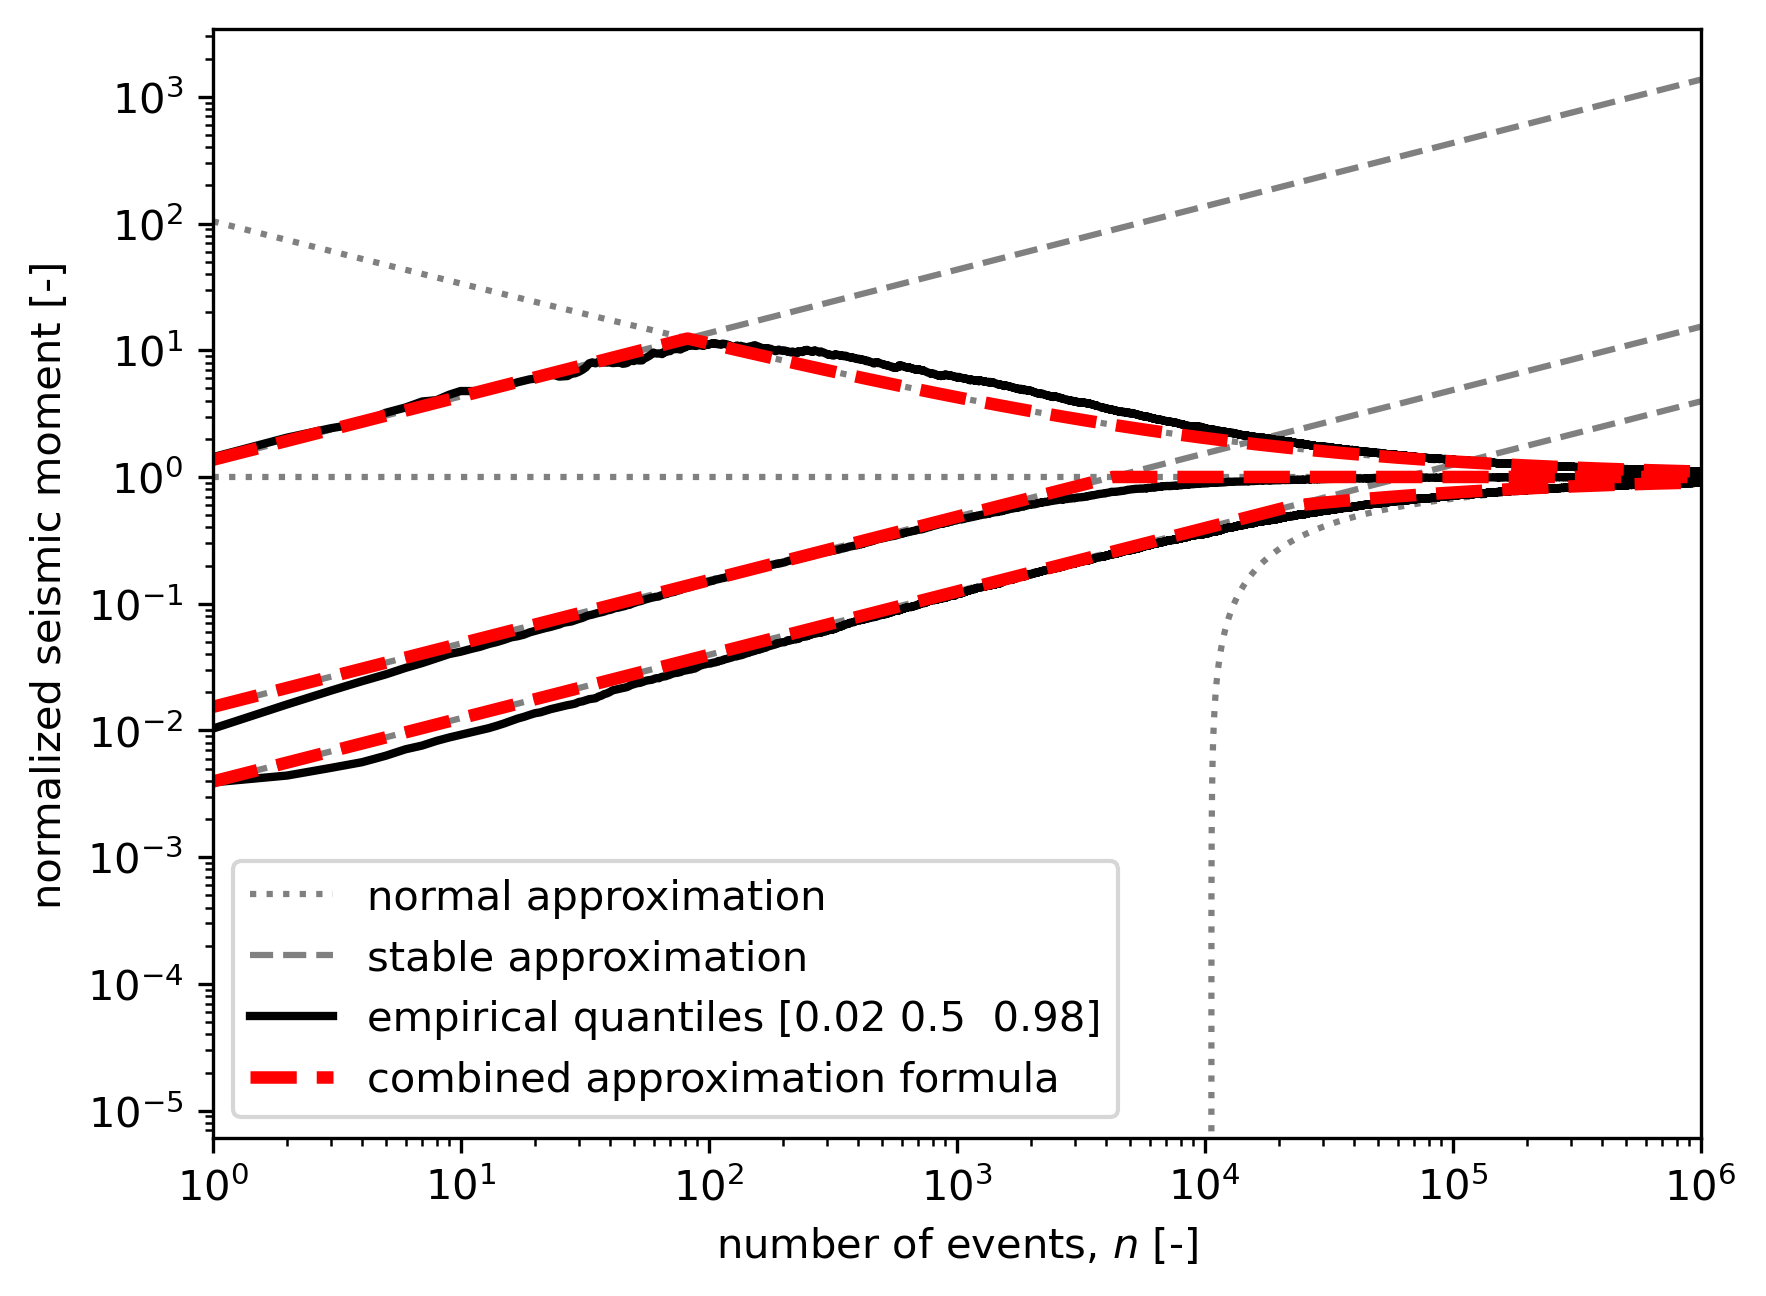

In [16]:
fig, ax = plt.subplots()
ax.set_xlim(count[0], count[-1])
ax.set_ylabel("normalized seismic moment [-]")
ax.set_xlabel("number of events, $n$ [-]")
plt.loglog(
    count,
    qnormal / ref,
    label=[f"normal approximation", None, None],
    linestyle=":",
    color="grey",
)
plt.loglog(
    count,
    qstable / ref,
    label=[f"stable approximation", None, None],
    linestyle="--",
    color="grey",
)
plt.loglog(
    count,
    moment_cumsum_percentiles / ref,
    label=[f"empirical quantiles {quantiles}", None, None],
    linestyle="-",
    color="black",
    linewidth=2,
)
plt.loglog(
    count,
    approx / ref,
    label=[f"combined approximation formula", None, None],
    linestyle="--",
    color="red",
    linewidth=3,
)
_ = plt.legend(loc="best")

## Case study: Alpine-Himalayan belt - Figure A4

### Settings

In [17]:
M_T = 2.0e17
M_C = 6.377e21
beta = 0.681
percentiles = np.array([2, 5, 50, 95, 98])
quantiles = np.array(percentiles) / 100.0
n_chain = 10**5  # from which the percentiles are calculated
n_draw = 3_500  # number of events in hypothetical catalog
mu = 27.7e9
D = 18.8e3
RANDOM_SEED = 42
tp_him = tp.tapered_pareto(beta, M_T, M_C)

In [18]:
rng = da.random.default_rng(RANDOM_SEED)
moment_samples = tp.sample_tapered_pareto(
    beta, M_T, M_C, rng=rng, size=(n_chain, n_draw), chunks=(-1, "auto")
)
moment_cumsum = moment_samples.cumsum(axis=1)
moment_cumsum_percentiles = (
    moment_cumsum.map_blocks(np.percentile, q=percentiles, axis=0).compute().T
)

In [19]:
expectation_value = tp_him.mean()
count = np.arange(1, n_draw + 1)
ref = count[:, None] * expectation_value
P_G = ref[:, 0] / (2 * mu * D)

In [20]:
approx = tp.quantile_approximator(quantiles[:, None], count, beta, M_T, M_C).T

In [21]:
norm_cumsum = moment_cumsum_percentiles / ref
norm_approx = approx / ref

### Figure A4

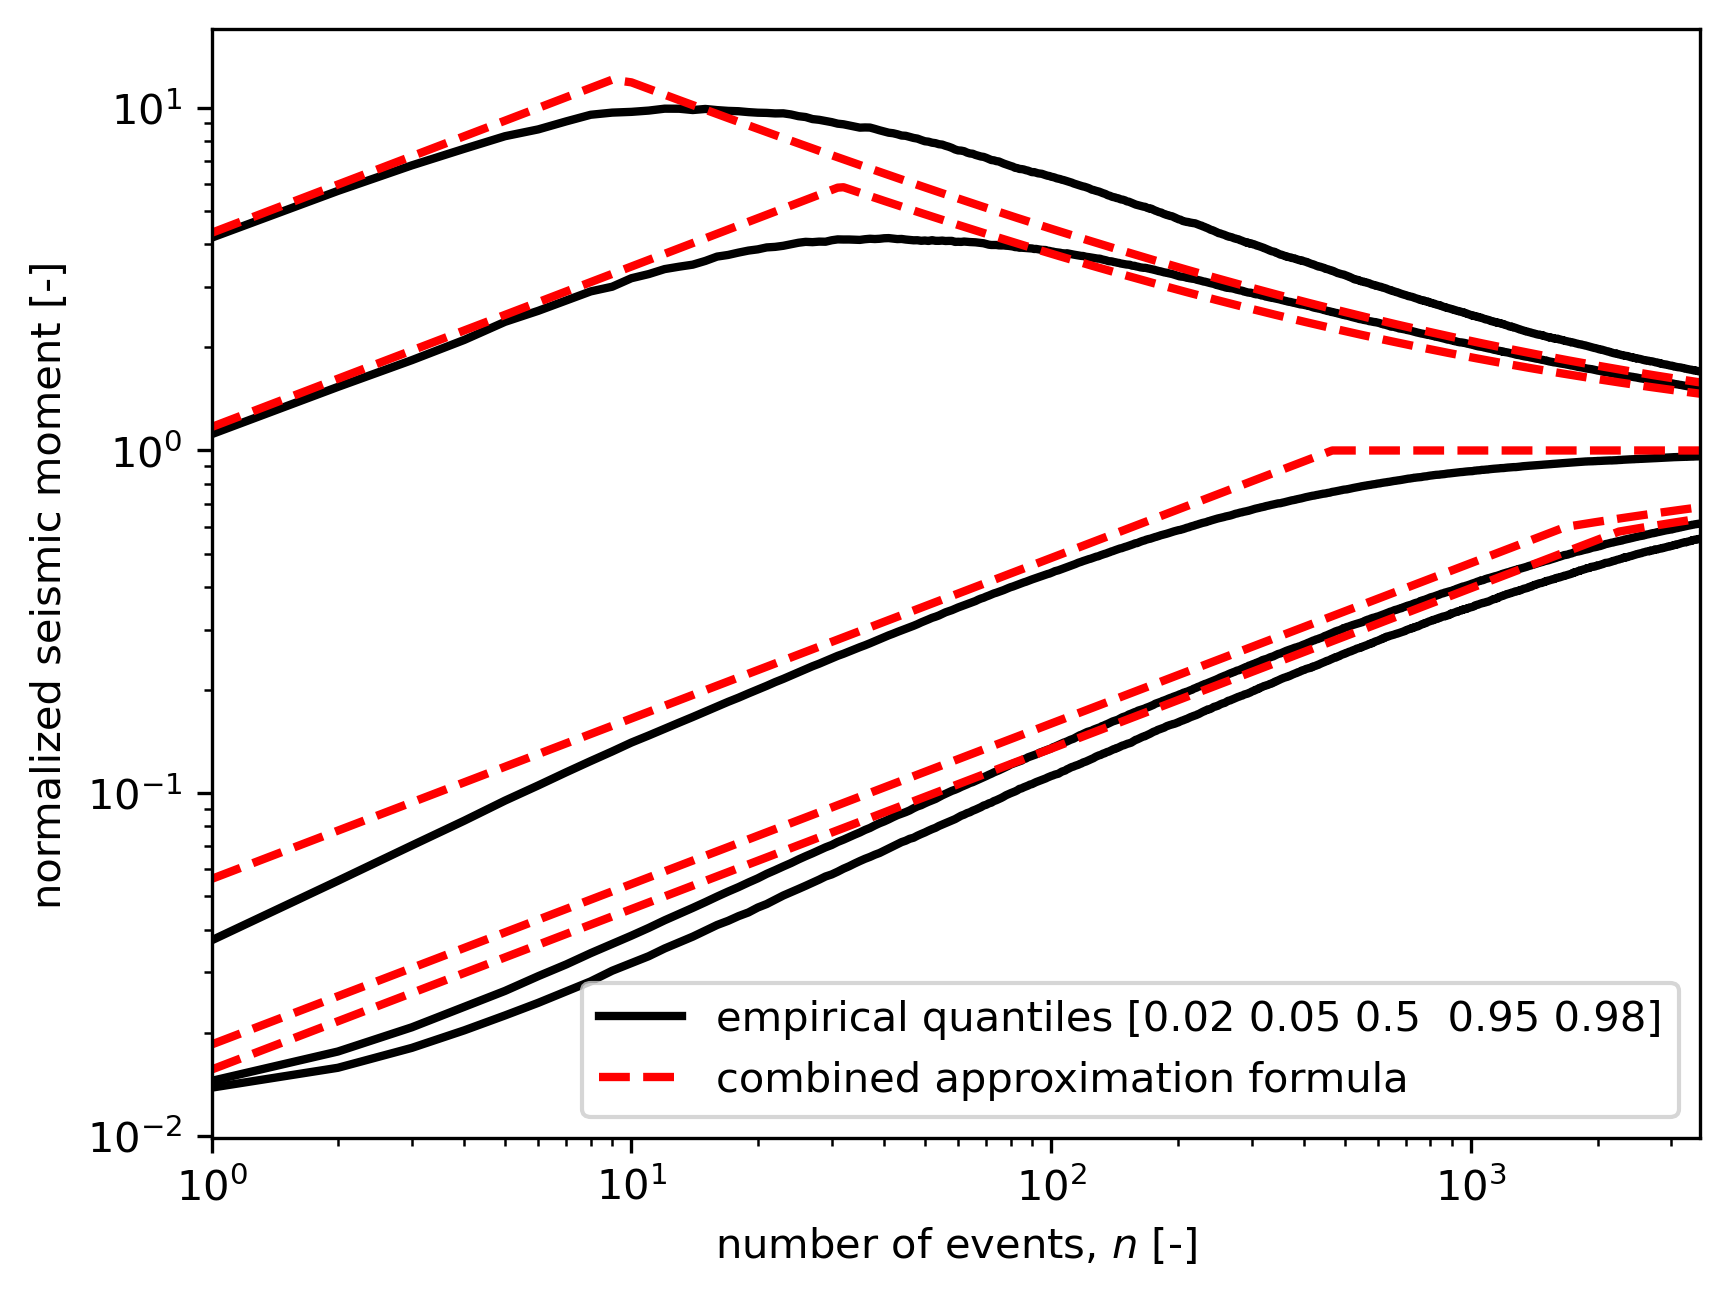

In [22]:
fig, ax = plt.subplots()
ax.set_xlim(count[0], count[-1])
ax.set_ylabel("normalized seismic moment [-]")
ax.set_xlabel("number of events, $n$ [-]")
plt.loglog(
    count,
    norm_cumsum,
    label=[f"empirical quantiles {quantiles}", None, None, None, None],
    linestyle="-",
    color="black",
    linewidth=2,
)
plt.loglog(
    count,
    norm_approx,
    label=[f"combined approximation formula", None, None, None, None],
    linestyle="--",
    color="red",
    linewidth=2,
)
_ = plt.legend(loc="best")